This program loads movie cover images, preprocesses them, trains a Self-Organizing Map on these images, and visualizes the images organized according to the SOM grid, grouping similar images together

In [1]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload

Covers of top 100 movies are loaded from the directory 'movie_covers'. 

Images are read using 'imageio.imread' and flattened using 'reshape'. The original shape of the images is recorded for later use.

Data is normalised using 'StandardScaler'

In [2]:
import numpy as np
import imageio
from glob import glob
from sklearn.preprocessing import StandardScaler

# covers of the top 100 movies on www.imdb.com/chart/top the 13th of August 2019
# images downloaded from www.themoviedb.org
data = []
all_covers = glob('movie_covers/*.jpg')
for cover_jpg in all_covers:
    cover = imageio.imread(cover_jpg)
    data.append(cover.reshape(np.prod(cover.shape)))
    
original_shape = imageio.imread(all_covers[0]).shape

scaler = StandardScaler()
data = scaler.fit_transform(data)

/var/folders/4x/fskdnqs169x0q3ppqc4rxgl40000gp/T/ipykernel_30149/3840552268.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cover = imageio.imread(cover_jpg)
/var/folders/4x/fskdnqs169x0q3ppqc4rxgl40000gp/T/ipykernel_30149/3840552268.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_shape = imageio.imread(all_covers[0]).shape


Setting Up and Training the Self-Organizing Map

The winning map (win_map) is obtained, which maps each input image to the best matching unit (BMU) on the SOM grid

In [3]:
from minisom import MiniSom

w = 10
h = 10
som = MiniSom(h, w, len(data[0]), learning_rate=0.5,
              sigma=3, neighborhood_function='triangle')

som.train_random(data, 2500, verbose=True)
win_map = som.win_map(data)

 [ 2500 / 2500 ] 100% - 0:00:00 left 
 quantization error: 106.90988153588712


In [4]:
som.activation_response(data)

array([[1., 1., 1., 0., 1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 1., 0., 0., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 0., 1., 1., 2.],
       [1., 1., 3., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 4., 1., 1., 1., 1., 0., 1., 1.],
       [2., 1., 1., 3., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 2., 1., 2., 1.]])

Visualizing the SOM

Images are placed corresponding to their BMUs. If multiple images map to the same node (collision), only the first image is placed initially.

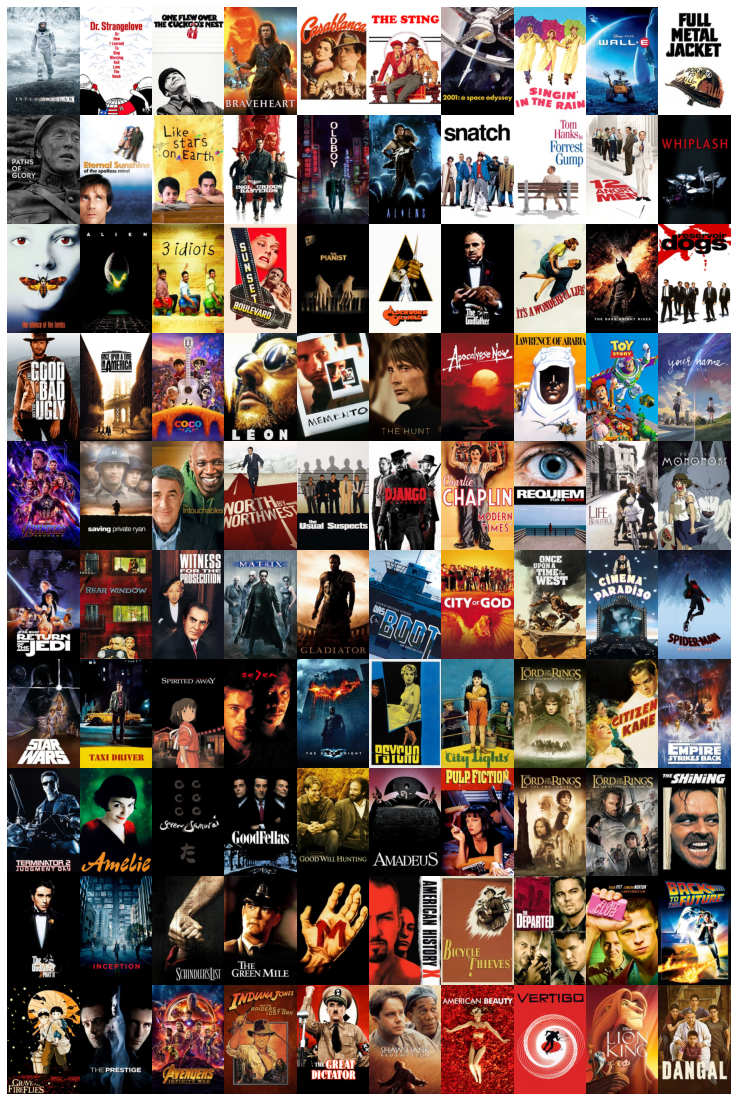

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(h, w), axes_pad=0)

def place_image(i, img):
    img = (scaler.inverse_transform(img.reshape(1, -1))).astype(int)
    grid[i].imshow(img.reshape(original_shape))
    grid[i].axis('off')

to_fill = []
collided = []

for i in range(w*h):
    position = np.unravel_index(i, (h, w))
    if position in win_map:
        img = win_map[position][0]
        collided += win_map[position][1:]
        place_image(i, img)
    else:
        to_fill.append(i)

collided = collided[::-1]
for i in to_fill:
    position = np.unravel_index(i, (h, w))
    img = collided.pop()
    place_image(i, img)

plt.show()